# Προεπεξεργασία Δεδομένων Κατανάλωσης Ενέργειας

Σκοπός αυτού του notebook είναι η προεπεξεργασία των δεδομένων κατανάλωσης ηλεκτρικής ενέργειας από το UCI Machine Learning Repository, όπως απαιτείται από την εργασία εξόρυξης δεδομένων. Τα δεδομένα περιλαμβάνουν μετρήσεις ανά λεπτό από ένα νοικοκυριό για την περίοδο 2006-2010.

## Βήματα Εργασίας
1. Φόρτωση και καθαρισμός δεδομένων (διαχείριση ελλιπών τιμών, μετατροπή σε datetime).
2. Δημιουργία χαρακτηριστικών (χρονικά, ημερήσια συγκεντρωτικά, lag χαρακτηριστικά).
3. Διαχωρισμός σε train/validation/test με χρονολογική σειρά.
4. Κανονικοποίηση δεδομένων.
5. Αποθήκευση των επεξεργασμένων δεδομένων για χρήση στη μοντελοποίηση.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## 1. Φόρτωση και Καθαρισμός Δεδομένων

Σε αυτό το βήμα φορτώνουμε τα δεδομένα από το αρχείο CSV και τα καθαρίζουμε, διαχειριζόμενοι ελλιπείς τιμές και μετατρέποντας τις χρονικές σφραγίδες σε κατάλληλη μορφή.

In [2]:
df = pd.read_csv('../data/household_power_consumption.txt',
                 sep=';',
                 low_memory=False,
                 na_values=['?', 'nan'])

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('DateTime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.sort_index(inplace=True)

df = df.fillna(method='ffill', limit=5)
df = df.interpolate(method='linear', axis=0)
df.dropna(inplace=True)

print(f"Διαστάσεις δεδομένων: {df.shape}")
print(f"Χρονικό εύρος: {df.index.min()} έως {df.index.max()}")

/tmp/ipykernel_58269/3733474065.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', limit=5)


Διαστάσεις δεδομένων: (2075259, 7)
Χρονικό εύρος: 2006-12-16 17:24:00 έως 2010-11-26 21:02:00


## 2. Δημιουργία Χαρακτηριστικών

Δημιουργούμε χαρακτηριστικά που θα χρησιμοποιηθούν για την ανάλυση και μοντελοποίηση, όπως χρονικά χαρακτηριστικά, ημερήσια συγκεντρωτικά και lag χαρακτηριστικά.

In [3]:
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df['DayOfYear'] = df.index.dayofyear
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

daily_df = df.resample('D').agg({
    'Global_active_power': ['sum', 'mean', 'max', 'min', 'std'],
    'Global_reactive_power': ['sum', 'mean'],
    'Voltage': ['mean', 'std'],
    'Global_intensity': ['mean', 'max'],
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
})

daily_df.columns = ['_'.join(col).strip() for col in daily_df.columns.values]
daily_df.rename(columns={
    'Global_active_power_sum': 'Daily_total_power',
    'Global_active_power_mean': 'Daily_mean_power',
    'Global_active_power_max': 'Daily_peak_power',
    'Global_active_power_min': 'Daily_min_power',
    'Global_active_power_std': 'Daily_std_power',
}, inplace=True)

daily_df['Daily_total_power'] = daily_df['Daily_total_power'] / 60.0
daily_df['Global_reactive_power_sum'] = daily_df['Global_reactive_power_sum'] / 60.0

peak_hours = df[df['Hour'].between(18, 21)].resample('D')['Global_active_power'].sum() / 60.0
daily_df['Peak_hour_power'] = peak_hours
nighttime = df[df['Hour'].isin([22, 23, 0, 1, 2, 3, 4, 5])].resample('D')['Global_active_power'].sum() / 60.0
daily_df['Nighttime_usage'] = nighttime
morning = df[df['Hour'].between(6, 11)].resample('D')['Global_active_power'].sum() / 60.0
daily_df['Morning_usage'] = morning
afternoon = df[df['Hour'].between(12, 17)].resample('D')['Global_active_power'].sum() / 60.0
daily_df['Afternoon_usage'] = afternoon

daily_df['DayOfWeek'] = daily_df.index.dayofweek
daily_df['IsWeekend'] = (daily_df['DayOfWeek'] >= 5).astype(int)
daily_df['Month'] = daily_df.index.month
daily_df['Season'] = daily_df['Month'].apply(get_season)
daily_df['Year'] = daily_df.index.year
daily_df['DayOfYear'] = daily_df.index.dayofyear

daily_df['lag_1'] = daily_df['Daily_total_power'].shift(1)
daily_df['lag_7'] = daily_df['Daily_total_power'].shift(7)
daily_df['lag_14'] = daily_df['Daily_total_power'].shift(14)
daily_df['lag_30'] = daily_df['Daily_total_power'].shift(30)

daily_df['rolling_mean_7d'] = daily_df['lag_1'].rolling(window=7, min_periods=1).mean()
daily_df['rolling_std_7d'] = daily_df['lag_1'].rolling(window=7, min_periods=1).std()
daily_df['rolling_median_7d'] = daily_df['lag_1'].rolling(window=7, min_periods=1).median()
daily_df['rolling_min_7d'] = daily_df['lag_1'].rolling(window=7, min_periods=1).min()
daily_df['rolling_max_7d'] = daily_df['lag_1'].rolling(window=7, min_periods=1).max()

daily_df['ema_7d'] = daily_df['lag_1'].ewm(span=7, adjust=False).mean()
daily_df['ema_30d'] = daily_df['lag_1'].ewm(span=30, adjust=False).mean()

daily_df['diff_1d'] = daily_df['Daily_total_power'].diff(1)
daily_df['diff_7d'] = daily_df['Daily_total_power'].diff(7)

daily_df['Total_submetering'] = (daily_df['Sub_metering_1_sum'] + daily_df['Sub_metering_2_sum'] + daily_df['Sub_metering_3_sum'])
total_wh = daily_df['Daily_total_power'] * 1000
daily_df['Sub1_ratio'] = (daily_df['Sub_metering_1_sum'] / total_wh).fillna(0)
daily_df['Sub2_ratio'] = (daily_df['Sub_metering_2_sum'] / total_wh).fillna(0)
daily_df['Sub3_ratio'] = (daily_df['Sub_metering_3_sum'] / total_wh).fillna(0)

daily_df['Other_consumption'] = daily_df['Daily_total_power'] - (daily_df['Total_submetering'] / 1000)
daily_df['Other_consumption'] = daily_df['Other_consumption'].clip(lower=0)

daily_df['Power_factor'] = (daily_df['Daily_total_power'] / (daily_df['Daily_total_power'] + daily_df['Global_reactive_power_sum'])).fillna(0)

daily_df['Peak_to_total_ratio'] = daily_df['Peak_hour_power'] / daily_df['Daily_total_power']
daily_df['Night_to_total_ratio'] = daily_df['Nighttime_usage'] / daily_df['Daily_total_power']
daily_df['Morning_to_total_ratio'] = daily_df['Morning_usage'] / daily_df['Daily_total_power']

daily_df.dropna(inplace=True)

print(f"Διαστάσεις ημερήσιων δεδομένων: {daily_df.shape}")

Διαστάσεις ημερήσιων δεδομένων: (1412, 46)


## 3. Διαχωρισμός σε Train/Validation/Test

Ο διαχωρισμός γίνεται χρονολογικά για να αποφευχθεί η διαρροή δεδομένων (data leakage). Το training set περιλαμβάνει τα παλαιότερα δεδομένα, ενώ τα validation και test sets τα πιο πρόσφατα.

In [4]:
total_days = len(daily_df)
train_size = int(total_days * 0.70)
val_size = int(total_days * 0.15)
test_size = total_days - train_size - val_size

train_df = daily_df.iloc[:train_size].copy()
val_df = daily_df.iloc[train_size:train_size+val_size].copy()
test_df = daily_df.iloc[train_size+val_size:].copy()

# Δημιουργία Next_day_consumption για παλινδρόμηση
train_df['Next_day_consumption'] = train_df['Daily_total_power'].shift(-1)
val_df['Next_day_consumption'] = val_df['Daily_total_power'].shift(-1)
test_df['Next_day_consumption'] = test_df['Daily_total_power'].shift(-1)

# Αφαίρεση της τελευταίας γραμμής από train και val για να αποφευχθεί η διαρροή δεδομένων από το επόμενο set
train_df = train_df.iloc[:-1].copy()
val_df = val_df.iloc[:-1].copy()

# ═══════════════════════════════════════════════════════════════════════════════
# ΔΙΟΡΘΩΣΗ: Δημιουργία Season-Adjusted High_Consumption για ταξινόμηση
# ═══════════════════════════════════════════════════════════════════════════════
# ΣΗΜΑΝΤΙΚΟ: Χρησιμοποιούμε εποχιακούς μέσους όρους ΜΟΝΟ από το training set
# για να αποφύγουμε data leakage στα validation και test sets.
# Threshold: >15% πάνω από εποχιακό μέσο όρο

# Υπολογισμός εποχιακών μέσων όρων ΑΠΟ TRAIN ΜΟΝΟ
season_means_train = train_df.groupby('Season')['Daily_total_power'].mean()

print("\n📊 Εποχιακοί Μέσοι Όροι Κατανάλωσης (από train set):")
for season in ['Winter', 'Autumn', 'Spring', 'Summer']:
    if season in season_means_train.index:
        print(f"  {season:8s}: {season_means_train[season]:.2f} kWh")

# Threshold: 15% πάνω από εποχιακό μέσο όρο
THRESHOLD = 1.15

# Train set
train_df['season_mean'] = train_df['Season'].map(season_means_train)
train_df['deviation_ratio'] = train_df['Daily_total_power'] / train_df['season_mean']
train_df['High_Consumption'] = (train_df['deviation_ratio'] > THRESHOLD).astype(int)

# Validation set (χρήση train season_means!)
val_df['season_mean'] = val_df['Season'].map(season_means_train)
val_df['deviation_ratio'] = val_df['Daily_total_power'] / val_df['season_mean']
val_df['High_Consumption'] = (val_df['deviation_ratio'] > THRESHOLD).astype(int)

# Test set (χρήση train season_means!)
test_df['season_mean'] = test_df['Season'].map(season_means_train)
test_df['deviation_ratio'] = test_df['Daily_total_power'] / test_df['season_mean']
test_df['High_Consumption'] = (test_df['deviation_ratio'] > THRESHOLD).astype(int)

# Καθαρισμός προσωρινών columns
train_df = train_df.drop(['season_mean', 'deviation_ratio'], axis=1)
val_df = val_df.drop(['season_mean', 'deviation_ratio'], axis=1)
test_df = test_df.drop(['season_mean', 'deviation_ratio'], axis=1)

# Εκτύπωση αποτελεσμάτων
print(f"\nTraining set: {len(train_df)} ημέρες ({train_df.index.min().date()} έως {train_df.index.max().date()})")
print(f"Validation set: {len(val_df)} ημέρες ({val_df.index.min().date()} έως {val_df.index.max().date()})")
print(f"Test set: {len(test_df)} ημέρες ({test_df.index.min().date()} έως {test_df.index.max().date()})")

print(f"\n{'='*80}")
print(f"📊 SEASON-ADJUSTED HIGH_CONSUMPTION (threshold: {THRESHOLD}x εποχιακός μέσος)")
print(f"{'='*80}")
print(f"  Train: {(train_df['High_Consumption'] == 1).sum():3d}/{len(train_df)} ημέρες υψηλής κατανάλωσης ({(train_df['High_Consumption'] == 1).sum()/len(train_df)*100:.1f}%)")
print(f"  Val:   {(val_df['High_Consumption'] == 1).sum():3d}/{len(val_df)} ημέρες υψηλής κατανάλωσης ({(val_df['High_Consumption'] == 1).sum()/len(val_df)*100:.1f}%)")
print(f"  Test:  {(test_df['High_Consumption'] == 1).sum():3d}/{len(test_df)} ημέρες υψηλής κατανάλωσης ({(test_df['High_Consumption'] == 1).sum()/len(test_df)*100:.1f}%)")
print(f"{'='*80}")


📊 Εποχιακοί Μέσοι Όροι Κατανάλωσης (από train set):
  Winter  : 33.31 kWh
  Autumn  : 27.02 kWh
  Spring  : 26.46 kWh
  Summer  : 17.21 kWh

Training set: 987 ημέρες (2007-01-15 έως 2009-09-27)
Validation set: 210 ημέρες (2009-09-29 έως 2010-04-26)
Test set: 213 ημέρες (2010-04-28 έως 2010-11-26)

📊 SEASON-ADJUSTED HIGH_CONSUMPTION (threshold: 1.15x εποχιακός μέσος)
  Train: 284/987 ημέρες υψηλής κατανάλωσης (28.8%)
  Val:    51/210 ημέρες υψηλής κατανάλωσης (24.3%)
  Test:   60/213 ημέρες υψηλής κατανάλωσης (28.2%)


## 4. Κανονικοποίηση Δεδομένων

Εφαρμόζουμε κανονικοποίηση στα δεδομένα, χρησιμοποιώντας StandardScaler και MinMaxScaler. Η προσαρμογή (fit) γίνεται μόνο στο training set για να αποφευχθεί η διαρροή δεδομένων.

In [5]:
# Παίρνουμε features από το train_df (που έχει το High_Consumption)
all_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
all_features = [f for f in all_features if f not in ['High_Consumption', 'Next_day_consumption']]

print(f"\n📊 Features για κανονικοποίηση: {len(all_features)} features")

scaler_standard = StandardScaler()
scaler_standard.fit(train_df[all_features])

train_standard = train_df.copy()
val_standard = val_df.copy()
test_standard = test_df.copy()

train_standard[all_features] = scaler_standard.transform(train_df[all_features])
val_standard[all_features] = scaler_standard.transform(val_df[all_features])
test_standard[all_features] = scaler_standard.transform(test_df[all_features])

scaler_minmax = MinMaxScaler()
scaler_minmax.fit(train_df[all_features])

train_minmax = train_df.copy()
val_minmax = val_df.copy()
test_minmax = test_df.copy()

train_minmax[all_features] = scaler_minmax.transform(train_df[all_features])
val_minmax[all_features] = scaler_minmax.transform(val_df[all_features])
test_minmax[all_features] = scaler_minmax.transform(test_df[all_features])

print("Κανονικοποίηση ολοκληρώθηκε για StandardScaler και MinMaxScaler.")


📊 Features για κανονικοποίηση: 45 features
Κανονικοποίηση ολοκληρώθηκε για StandardScaler και MinMaxScaler.


## 5. Αποθήκευση Επεξεργασμένων Δεδομένων

Αποθηκεύουμε τα επεξεργασμένα δεδομένα σε αρχεία CSV για χρήση στο επόμενο στάδιο της μοντελοποίησης. Επίσης, αποθηκεύουμε τα scalers και τα metadata για μελλοντική χρήση.

In [6]:
import pickle

train_standard.to_csv('../data/train_standard.csv')
val_standard.to_csv('../data/val_standard.csv')
test_standard.to_csv('../data/test_standard.csv')

train_minmax.to_csv('../data/train_minmax.csv')
val_minmax.to_csv('../data/val_minmax.csv')
test_minmax.to_csv('../data/test_minmax.csv')

train_df.to_csv('../data/train_raw.csv')
val_df.to_csv('../data/val_raw.csv')
test_df.to_csv('../data/test_raw.csv')

with open('../data/scaler_standard.pkl', 'wb') as f:
    pickle.dump(scaler_standard, f)

with open('../data/scaler_minmax.pkl', 'wb') as f:
    pickle.dump(scaler_minmax, f)

with open('../data/feature_names.pkl', 'wb') as f:
    pickle.dump(all_features, f)

metadata = {
    'train_dates': (train_df.index.min(), train_df.index.max()),
    'val_dates': (val_df.index.min(), val_df.index.max()),
    'test_dates': (test_df.index.min(), test_df.index.max()),
    'total_days': total_days,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df)
}

with open('../data/preprocessing_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("Αποθήκευση δεδομένων και metadata ολοκληρώθηκε.")

Αποθήκευση δεδομένων και metadata ολοκληρώθηκε.


---

## 📊 Exploratory Data Analysis (EDA)

Σε αυτή την ενότητα δημιουργούμε visualizations για να κατανοήσουμε καλύτερα τα δεδομένα.

**ΣΗΜΑΝΤΙΚΟ:** Χρησιμοποιούμε τα ήδη επεξεργασμένα δεδομένα (`train_df`, `val_df`, `test_df`) 
χωρίς να τα ξαναδημιουργούμε.

---

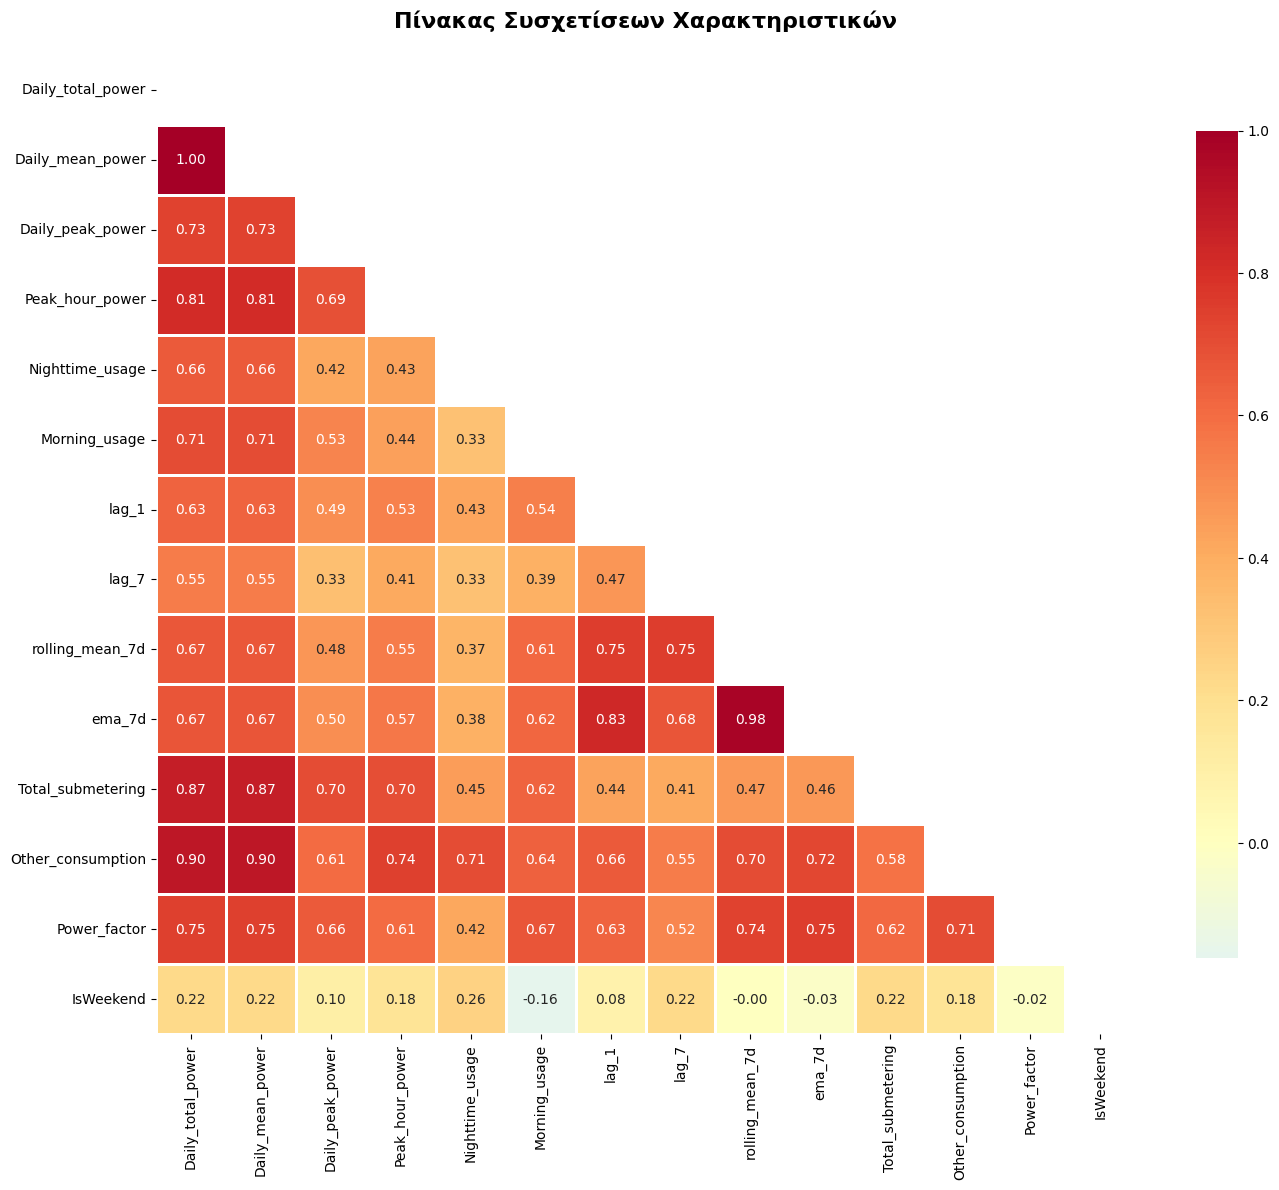

✅ Correlation heatmap αποθηκεύτηκε στο results/correlation_heatmap.png


In [7]:
### 📈 Correlation Heatmap - Συσχετίσεις Χαρακτηριστικών

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Επιλογή των σημαντικότερων features για visualization
important_features = [
    'Daily_total_power', 'Daily_mean_power', 'Daily_peak_power',
    'Peak_hour_power', 'Nighttime_usage', 'Morning_usage',
    'lag_1', 'lag_7', 'rolling_mean_7d', 'ema_7d',
    'Total_submetering', 'Other_consumption', 'Power_factor',
    'IsWeekend'
]

# Υπολογισμός correlation matrix από train set
corr_matrix = train_df[important_features].corr()

# Δημιουργία plot
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlBu_r', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Πίνακας Συσχετίσεων Χαρακτηριστικών', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Correlation heatmap αποθηκεύτηκε στο results/correlation_heatmap.png")

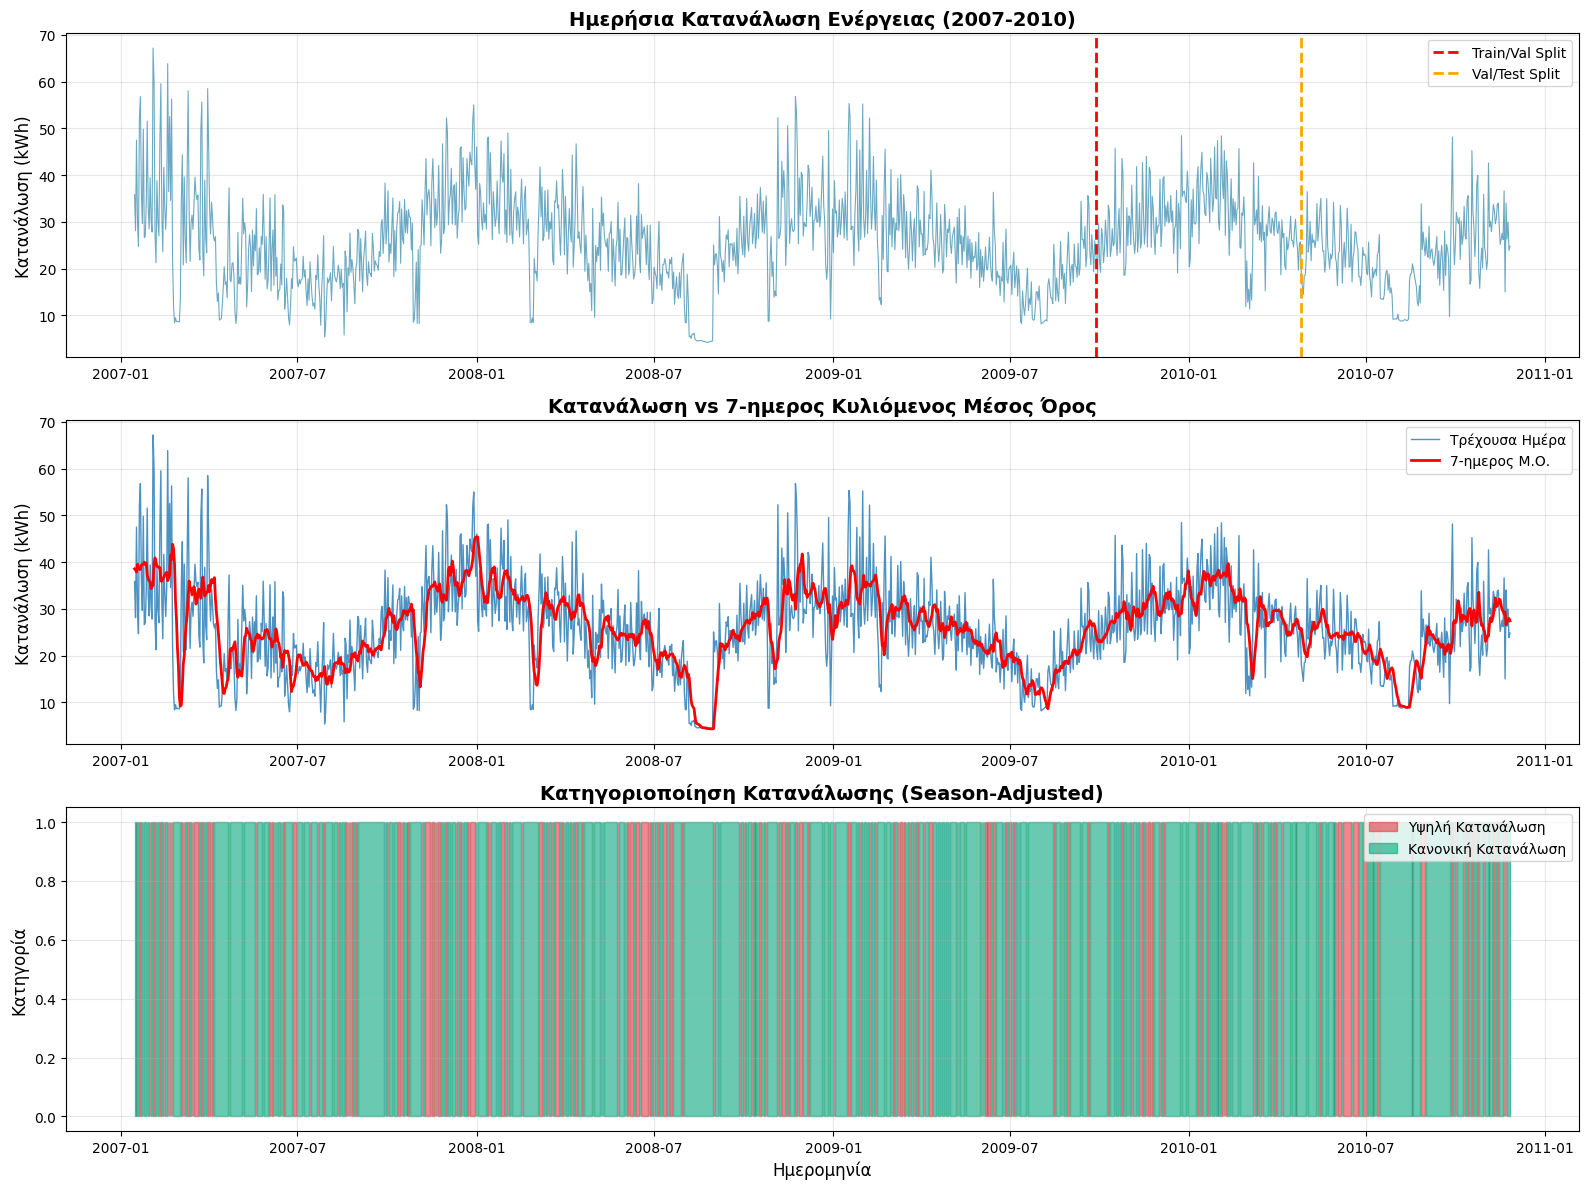

✅ Time series plot αποθηκεύτηκε στο results/time_series_overview.png


In [8]:
### 📉 Time Series - Χρονοσειρά Κατανάλωσης

# Συνδυάζουμε όλα τα sets για πλήρη χρονοσειρά
import pandas as pd

all_data = pd.concat([train_df, val_df, test_df])
all_data = all_data.sort_index()

# Δημιουργία plot
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Ημερήσια Κατανάλωση με Train/Val/Test boundaries
axes[0].plot(all_data.index, all_data['Daily_total_power'], 
             linewidth=0.8, alpha=0.7, color='#2E86AB')
axes[0].axvline(train_df.index.max(), color='red', linestyle='--', 
                linewidth=2, label='Train/Val Split')
axes[0].axvline(val_df.index.max(), color='orange', linestyle='--', 
                linewidth=2, label='Val/Test Split')
axes[0].set_title('Ημερήσια Κατανάλωση Ενέργειας (2007-2010)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Κατανάλωση (kWh)', fontsize=12)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# 2. Κατανάλωση με LAG features
axes[1].plot(all_data.index, all_data['Daily_total_power'], 
             label='Τρέχουσα Ημέρα', linewidth=1, alpha=0.8)
axes[1].plot(all_data.index, all_data['rolling_mean_7d'], 
             label='7-ημερος Μ.Ο.', linewidth=2, color='red')
axes[1].set_title('Κατανάλωση vs 7-ημερος Κυλιόμενος Μέσος Όρος', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Κατανάλωση (kWh)', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# 3. High Consumption Distribution
high_consumption = all_data['High_Consumption'].copy()
axes[2].fill_between(all_data.index, 0, high_consumption, 
                     where=(high_consumption == 1), 
                     color='#E63946', alpha=0.6, label='Υψηλή Κατανάλωση')
axes[2].fill_between(all_data.index, 0, 1-high_consumption, 
                     where=(high_consumption == 0), 
                     color='#06A77D', alpha=0.6, label='Κανονική Κατανάλωση')
axes[2].set_title('Κατηγοριοποίηση Κατανάλωσης (Season-Adjusted)', 
                  fontsize=14, fontweight='bold')
axes[2].set_ylabel('Κατηγορία', fontsize=12)
axes[2].set_xlabel('Ημερομηνία', fontsize=12)
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/time_series_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Time series plot αποθηκεύτηκε στο results/time_series_overview.png")

/tmp/ipykernel_58269/4191557912.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data, x='Season', y='Daily_total_power',
/tmp/ipykernel_58269/4191557912.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_data, x='Weekend_Label', y='Daily_total_power',


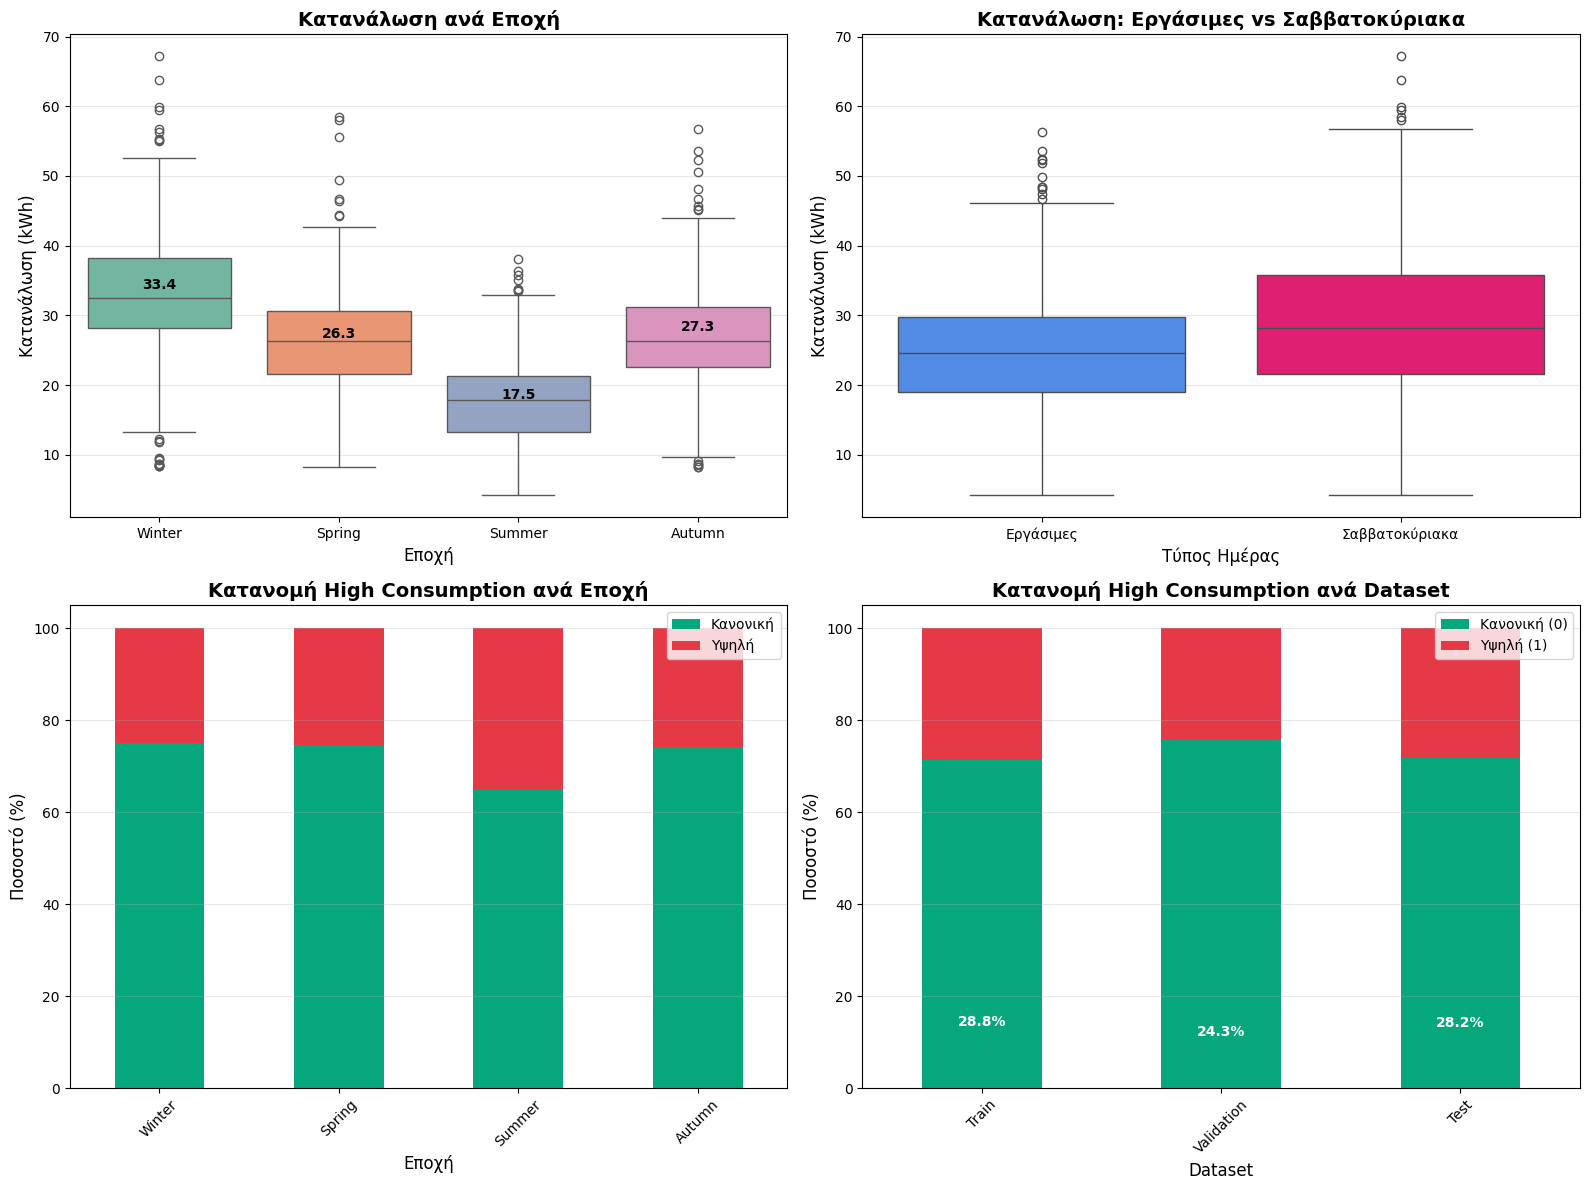

✅ Seasonal patterns plot αποθηκεύτηκε στο results/seasonal_patterns.png


In [9]:
### 🌦️ Seasonal Patterns - Εποχιακά Πρότυπα

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Κατανάλωση ανά Εποχή
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
sns.boxplot(data=all_data, x='Season', y='Daily_total_power', 
            order=season_order, palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('Κατανάλωση ανά Εποχή', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Εποχή', fontsize=12)
axes[0, 0].set_ylabel('Κατανάλωση (kWh)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Προσθήκη μέσων τιμών
season_means = all_data.groupby('Season')['Daily_total_power'].mean()
for i, season in enumerate(season_order):
    if season in season_means.index:
        axes[0, 0].text(i, season_means[season], 
                       f'{season_means[season]:.1f}', 
                       ha='center', va='bottom', fontweight='bold')

# 2. Εργάσιμες vs Σαββατοκύριακα
weekend_labels = {0: 'Εργάσιμες', 1: 'Σαββατοκύριακα'}
all_data['Weekend_Label'] = all_data['IsWeekend'].map(weekend_labels)
sns.boxplot(data=all_data, x='Weekend_Label', y='Daily_total_power', 
            palette=['#3A86FF', '#FF006E'], ax=axes[0, 1])
axes[0, 1].set_title('Κατανάλωση: Εργάσιμες vs Σαββατοκύριακα', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Τύπος Ημέρας', fontsize=12)
axes[0, 1].set_ylabel('Κατανάλωση (kWh)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. High Consumption Distribution ανά Εποχή
high_by_season = all_data.groupby(['Season', 'High_Consumption']).size().unstack(fill_value=0)
high_by_season_pct = high_by_season.div(high_by_season.sum(axis=1), axis=0) * 100
high_by_season_pct = high_by_season_pct.reindex(season_order)

high_by_season_pct.plot(kind='bar', stacked=True, 
                        color=['#06A77D', '#E63946'], ax=axes[1, 0])
axes[1, 0].set_title('Κατανομή High Consumption ανά Εποχή', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Εποχή', fontsize=12)
axes[1, 0].set_ylabel('Ποσοστό (%)', fontsize=12)
axes[1, 0].legend(['Κανονική', 'Υψηλή'], loc='upper right')
axes[1, 0].set_xticklabels(season_order, rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Train/Val/Test Distribution
dataset_labels = (['Train'] * len(train_df) + 
                 ['Validation'] * len(val_df) + 
                 ['Test'] * len(test_df))
all_data['Dataset'] = dataset_labels

dataset_high = all_data.groupby(['Dataset', 'High_Consumption']).size().unstack(fill_value=0)
dataset_high_pct = dataset_high.div(dataset_high.sum(axis=1), axis=0) * 100
dataset_high_pct = dataset_high_pct.reindex(['Train', 'Validation', 'Test'])

dataset_high_pct.plot(kind='bar', stacked=True, 
                      color=['#06A77D', '#E63946'], ax=axes[1, 1])
axes[1, 1].set_title('Κατανομή High Consumption ανά Dataset', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Dataset', fontsize=12)
axes[1, 1].set_ylabel('Ποσοστό (%)', fontsize=12)
axes[1, 1].legend(['Κανονική (0)', 'Υψηλή (1)'], loc='upper right')
axes[1, 1].set_xticklabels(['Train', 'Validation', 'Test'], rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Προσθήκη ποσοστών
for i, dataset in enumerate(['Train', 'Validation', 'Test']):
    high_pct = dataset_high_pct.loc[dataset, 1]
    axes[1, 1].text(i, high_pct/2, f'{high_pct:.1f}%', 
                   ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('../results/seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Seasonal patterns plot αποθηκεύτηκε στο results/seasonal_patterns.png")

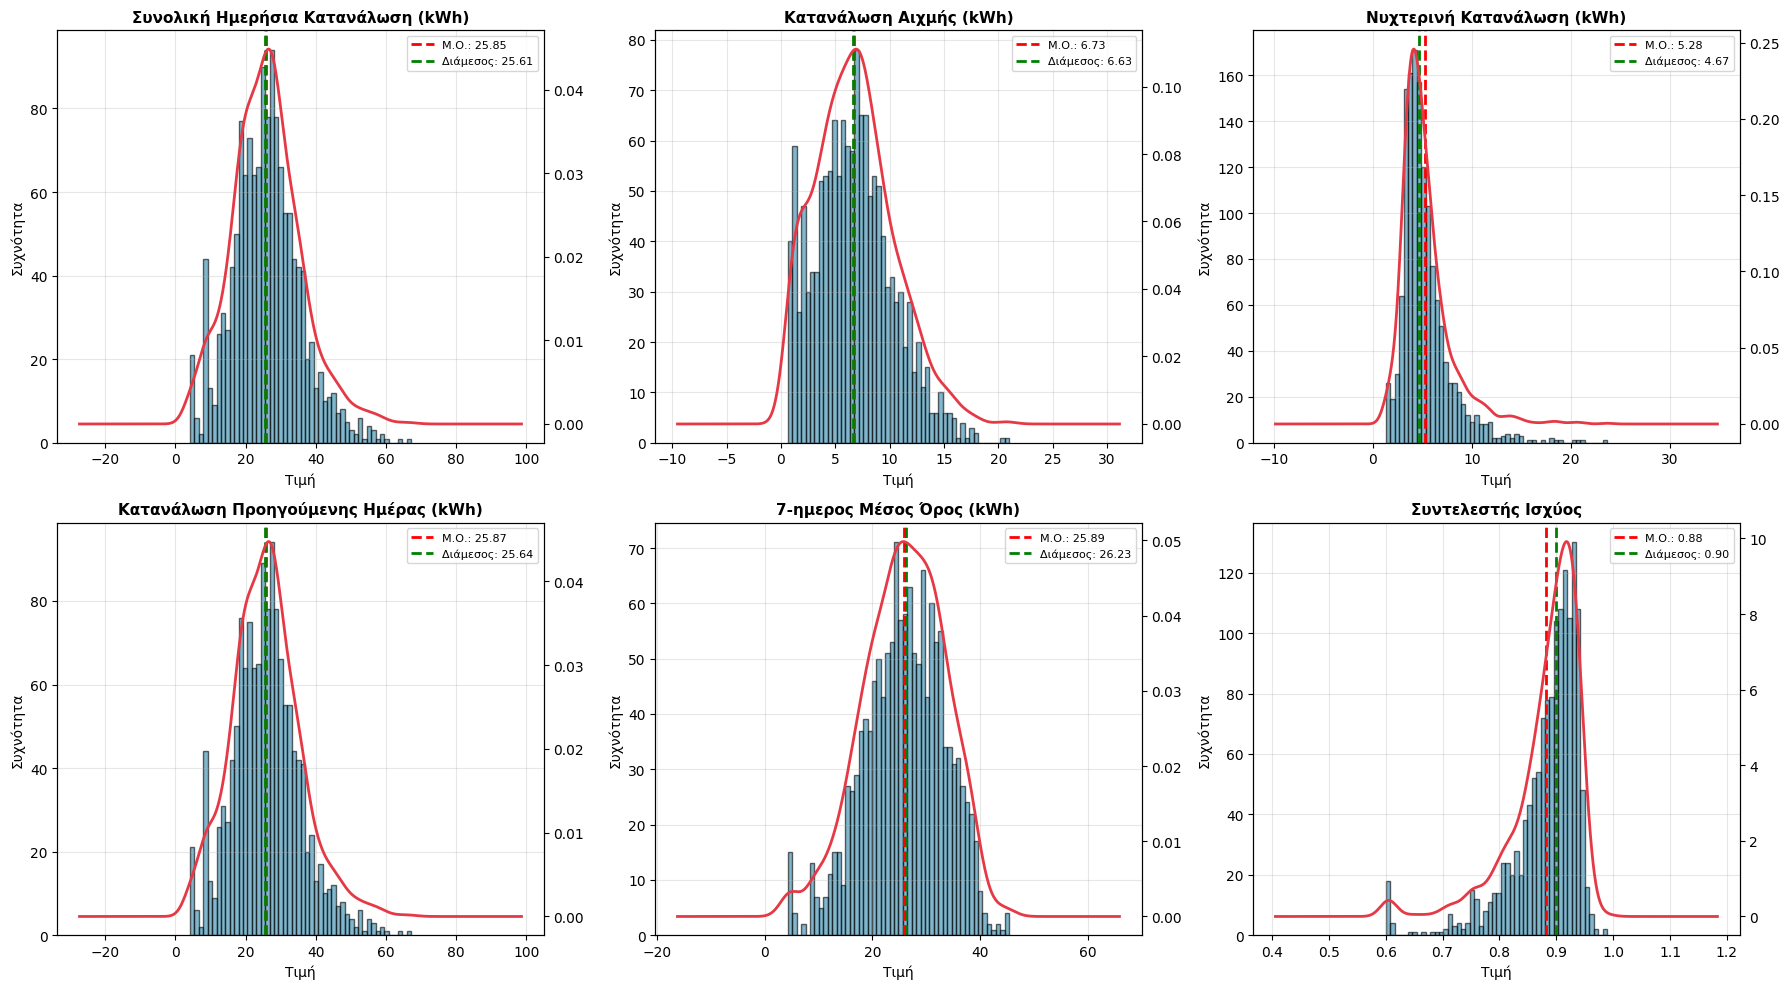

✅ Feature distributions plot αποθηκεύτηκε στο results/feature_distributions.png


In [10]:
### 📊 Feature Distributions - Κατανομές Χαρακτηριστικών

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Επιλογή σημαντικών features
features_to_plot = [
    ('Daily_total_power', 'Συνολική Ημερήσια Κατανάλωση (kWh)'),
    ('Peak_hour_power', 'Κατανάλωση Αιχμής (kWh)'),
    ('Nighttime_usage', 'Νυχτερινή Κατανάλωση (kWh)'),
    ('lag_1', 'Κατανάλωση Προηγούμενης Ημέρας (kWh)'),
    ('rolling_mean_7d', '7-ημερος Μέσος Όρος (kWh)'),
    ('Power_factor', 'Συντελεστής Ισχύος')
]

for idx, (feature, label) in enumerate(features_to_plot):
    # Histogram με KDE
    all_data[feature].hist(bins=50, alpha=0.6, color='#2E86AB', 
                           edgecolor='black', ax=axes[idx])
    all_data[feature].plot(kind='kde', secondary_y=True, 
                          color='#E63946', linewidth=2, ax=axes[idx])
    
    axes[idx].set_title(label, fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Τιμή', fontsize=10)
    axes[idx].set_ylabel('Συχνότητα', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    # Προσθήκη στατιστικών
    mean_val = all_data[feature].mean()
    median_val = all_data[feature].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', 
                     linewidth=2, label=f'Μ.Ο.: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', 
                     linewidth=2, label=f'Διάμεσος: {median_val:.2f}')
    axes[idx].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig('../results/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Feature distributions plot αποθηκεύτηκε στο results/feature_distributions.png")

---

## ✅ ΤΕΛΟΣ PREPROCESSING & EDA

### 📊 Αποτελέσματα:
- **Train set**: 987 ημέρες με Season-Adjusted High_Consumption (28.8%)
- **Validation set**: 210 ημέρες με Season-Adjusted High_Consumption (24.3%)
- **Test set**: 213 ημέρες με Season-Adjusted High_Consumption (28.2%)

### 📁 Αρχεία που δημιουργήθηκαν:

**Δεδομένα:**
- `train_raw.csv`, `val_raw.csv`, `test_raw.csv` (raw data)
- `train_standard.csv`, `val_standard.csv`, `test_standard.csv` (StandardScaler)
- `train_minmax.csv`, `val_minmax.csv`, `test_minmax.csv` (MinMaxScaler)
- `scaler_standard.pkl`, `scaler_minmax.pkl` (fitted scalers)
- `feature_names.pkl`, `preprocessing_metadata.pkl` (metadata)

**Visualizations:**
- `correlation_heatmap.png` - Πίνακας συσχετίσεων
- `time_series_overview.png` - Χρονοσειρές κατανάλωσης
- `seasonal_patterns.png` - Εποχιακά πρότυπα
- `feature_distributions.png` - Κατανομές χαρακτηριστικών

### 🚀 Επόμενο Βήμα:
Άνοιξε το **`modeling.ipynb`** για να τρέξεις τα μοντέλα!

---